# Classification - Bank Direct Marketing example

## 0 Problem description / Objectives

In this project I analyze the data Resulting from a direct marketing campaign of the Portuguese Bank. In particular I try to predict if a client subscribes (or not) a term deposit, using its information and the outcome of previous campaigns.

To achieve this, I use machine learning classification algorithms, such as logistic regression and random forests.

### 0.1 Key Outputs

This analysis is useful for marketing / sales manager:

1. To know what are the factors that influence the success or not of a sale. In this case (let's say that are those who have a greater importance than 5%)

  1. The result of past campaigns.
  2. The client's age.
  3. Has the client a housing loan? 
  
  Using these variables the manager can target groups of customers and adjust its strategies accordingly in order to boost sales
2. If there are limitations of resources and the bank cannot contact all the customers, these classification algorithms can help to choose the group of customers most likely to adhere to the campaign.

In [2]:
# importing packages
from matplotlib import pyplot
import seaborn as sb
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1 Data extraction

The data used for this analysis was extracted from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [3]:
df = pd.read_csv("C:\\Users\\laptop\\Documents\\DataScience\\bank\\bank-full.csv", sep=";")
print df.head()

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


### 1.1 Data Description

#### Bank client data
* **age** (numeric)
* **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* **education** : (categorical: 'primary','secondary','tertiary','unknown')
* **default** : has credit in default? (categorical: 'no','yes')
* **balance** (numeric)
* **housing** : has housing loan? (categorical: 'no','yes')
* **loan**: has personal loan? (categorical: 'no','yes')

#### Related with the current campaign:

* **contact** : contact communication type (categorical: 'cellular','telephone','unknown')
* **month** : last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* **day_of_week** : last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* **duration** : last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* **campaign** : number of contacts performed during this campaign and for this client (numeric, includes last contact)

#### Related with previous campaigns:
* **pdays** : number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
* **previous** : number of contacts performed before this campaign and for this client (numeric)
* **poutcome** : outcome of the previous marketing campaign (categorical: 'failure','success','other','unknown')

#### Output variable (desired target):
* **y** - has the client subscribed a term deposit? (binary: 'yes','no')

## 2 Data Preparation

In [872]:
# mudar para features

features = pd.DataFrame()
features['age'] = df['age']
features['balance'] = df['balance']
features = pd.concat([
        features,
        pd.get_dummies(df['job'], prefix='job'),
        pd.get_dummies(df['education'], prefix='educ')], axis=1)
features['housing_loan'] = df['housing'] == 'yes'
features['personal_loan'] = df['loan'] == 'yes'
features['credit_default'] = df['default'] == 'yes'
features['previous_outcome'] = 1 * (df['poutcome'] == 'success') - 1 * (df['poutcome'] == 'failure')

features_names = list(features.columns) # saving feature names

features = 1.0 * features # convert int and boolean data to float

X = features.values
y = (df['y'] == 'yes').values

from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=0)

## 3 Naive Bayes

In [705]:
from sklearn import naive_bayes, metrics
gnb = naive_bayes.GaussianNB()

## 4 Performance Measurement

Classification models such as Gaussian Naive Bayes are probabilities, that is, instead of just predicting a binary outcome given the input features it can also estimates the posterior probability of the outcome given the input features using the predict_proba method.

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the Receiving Operating Characteristic curve - ROC curve - and quantifying the Area under the ROC curve (AUC).

0.679212404979


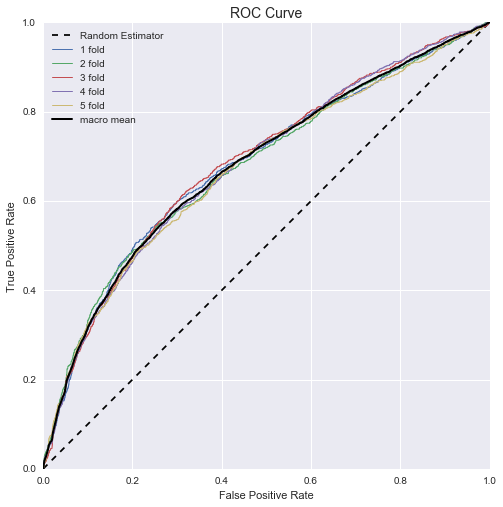

In [869]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

class multiclassROC:
    def __init__(self, clf, folds = KFold(5, shuffle=True)):
        self.clf = clf
        self.folds = folds
    
    def fit(self, X, y):
        i = 0
        n_classes = self.folds.n_splits
        self.fpr = []
        self.tpr = []
        self.auc = 0
        for train, test in self.folds.split(X):
            clf.fit(X[train], y[train])
            fpr, tpr, _ = roc_curve(y[test], clf.predict_proba(X[test])[:, 1])
            self.fpr.append(fpr)
            self.tpr.append(tpr)
            self.auc += auc(fpr, tpr) / n_classes
            i += 1
        
        self.macro = dict()
        self.macro['fpr'] = np.unique(np.concatenate([self.fpr[i] for i in range(self.folds.n_splits)]))
        self.macro['tpr'] = np.zeros_like(self.macro['fpr'])
        for i in range(n_classes):
            self.macro['tpr'] += interp(self.macro['fpr'], self.fpr[i], self.tpr[i]) / n_classes
        self.macro_auc = auc(self.macro['fpr'], self.macro['tpr'])
        
        return self
        
    
    def plot(self, legend=True, size=(8,8)):
        pyplot.figure(figsize=size)
        pyplot.title('ROC Curve', size=14)
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.plot([0, 1], [0, 1], 'k--', label='Random Estimator')
        for i in xrange(self.folds.n_splits):
            pyplot.plot(self.fpr[i], self.tpr[i], linestyle='steps', linewidth=1, label='%d fold' % (i+1))
        pyplot.plot(self.macro['fpr'], self.macro['tpr'], linewidth=2, color='black', label='macro mean')
        if legend:
            pyplot.legend(loc='upper left', shadow=True)

mc = multiclassROC(gnb)
mc.fit(X, y)
mc.plot()
print mc.auc

## 5 Learning Curve / Bias - Variance tradeoff

If a model is too complex for a given training dataset - there are too many degrees of freedom or parameters in this model - the model tens to overfit the training data and does not generalize well to unseen data.

By plotting the model training and validation accuracies as functions of the training set size, we can easily detect wheder the model suggers from high variance (overfitting) or high bias (undefitting).

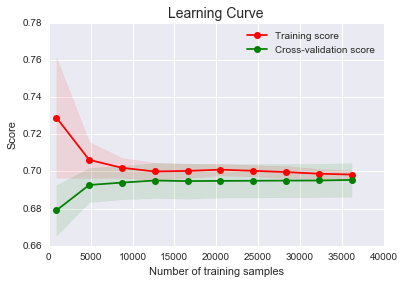

In [781]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

class clf_learning_curve:
    def __init__(self, clf, cv=ShuffleSplit(n_splits=10, test_size=0.2), scoring='roc_auc', random_state=1):
        self.clf = clf
        self.cv = cv
        self.scoring = scoring
    def fit(self, X, y):
        self.train_sizes, self.train_scores, self.test_scores = learning_curve(
            self.clf, X, y,
            cv=self.cv,
            scoring=self.scoring,
            train_sizes=np.linspace(.05, 1.0, 10))
        self.train_scores_mean = np.mean(self.train_scores, axis=1)
        self.train_scores_std = np.std(self.train_scores, axis=1)
        self.test_scores_mean = np.mean(self.test_scores, axis=1)
        self.test_scores_std = np.std(self.test_scores, axis=1)
        return self

    def plot(self):
        pyplot.fill_between(
            self.train_sizes,
            self.train_scores_mean - self.train_scores_std,
            self.train_scores_mean + self.train_scores_std,
            alpha=0.1, color="r")
        pyplot.fill_between(
            self.train_sizes,
            self.test_scores_mean - self.test_scores_std,
            self.test_scores_mean + self.test_scores_std,
            alpha=0.1, color="g")
        pyplot.plot(
            self.train_sizes,
            self.train_scores_mean,
            'o-', color="r", label="Training score")
        pyplot.plot(
            self.train_sizes,
            self.test_scores_mean,
            'o-', color="g", label="Cross-validation score")
        pyplot.title('Learning Curve', size=14)
        pyplot.xlabel('Number of training samples')
        pyplot.ylabel('Score')
        pyplot.legend(loc='upper right')

clf_learning_curve(gnb).fit(X, y).plot()

As we see in the plot, as the number of the training samples increase the validation accuracy (cross-validation score) increases and the training accuracy decreases.
We observe that around 10,000 training samples stabilities, reaching a plateau.

## 6 Data preprocessing

### 6.1 Derived Features

In [879]:
# features['neg_balance'] = 1.0 * (features['balance'] < 0)
features['log_balance'] = np.log1p(features['balance'].abs()) * np.sign(features['balance'])
features['loan'] = (features['housing_loan'] == 1) | (features['personal_loan'] == 1)
features['log_age'] = np.log(features['age'])

features_names = list(features.columns) # saving feature names

X = features.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=0)

### 6.2 Missing Data
Althought in data preparation we dind't consir that we have missing data in fact we have it:
1. For previous_outcome we considered that the feature is zero if the client wasnt contracted in previous campaings, (1 or -1 if the  however, 
2. If the job or the education was unknown, we used a custom feature to indicate it, however, we should impute NaN values for the job / education features when it was unknown, since the client may have one of these jobs / education.

In [874]:
features['previous_outcome'][features['previous_outcome'] == 0] = np.nan
# se job e unknow entao por nans
features.ix[features.job_unknown == 1, range(2,12)] = np.nan
features.drop('job_unknown', 1, inplace=True)

features.ix[features.educ_unknown == 1, range(13, 16)] = np.nan
features.drop('educ_unknown', 1, inplace=True)

features_names = list(features.columns) # saving feature names

X = features.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=0)

Now we need to attribute a value to the missing values, since most of the classifiers (as the Gaussian Naive Bayes) doesn't accept NaN values.

mean of median

However, it is ***critical*** to point that we cannot use the whole data set to estimate those values, since in that case we will be transposing test set information in the training set (and this is a kind of 'cheating').

Since the training set may change, we need to create a pipeline, with a data imputer and our gaussian naive bayes classifier. Hence, the imputer will calculate the means (or modes) only using the data that would be feed to it.

0.703836844918


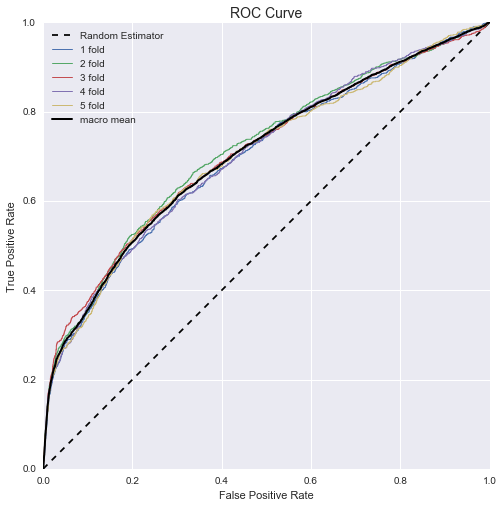

In [895]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
clf = Pipeline([
        ('imp', imputer),
        ('gnb', gnb)])

# measure performance
val = multiclassROC(clf).fit(X, y)
print val.auc
val.plot()

## 7 Feature Selection

In [896]:
from sklearn.base import TransformerMixin
class SFFS(TransformerMixin): # Sequential Foward Feature Selection
    def __init__(self, clf, cv=10, random_state=0):
        self.clf = sklearn.base.clone(clf)
        self.cv = cv
        self.random_state = random_state
    
    def fit(self, X, y):
        n_features = X.shape[1]
        self.indices_ = np.array([], dtype=np.int)
        self.score_ = .5
        for i in xrange(n_features):
            step_score = []
            subsets = []
            # p em arange(n_features) - self.indices
            for p in np.delete(np.arange(n_features, dtype=np.int), self.indices_):
                idx = np.append(self.indices_, p)
                s = cross_val_score(clf, X[:, idx], y, cv=self.cv, scoring='roc_auc').mean()
                step_score.append(s)
                subsets.append(idx)
            best = np.argmax(step_score)
            best_score = step_score[best]
            self.indices_ = subsets[best]
            print i, best_score
            if best_score >= self.score_:
                self.score_ = best_score
            else:
                break
        return self

    def transform(self, X):
        return X[:, self.indices_]

bs = SFFS(clf)
bs.fit(X, y)
print np.array(features_names)[bs.indices_]
print features_names[-5]

0 0.620173263498
1 0.668972655124
2 0.694524553406
3 0.705768733807
4 0.713091183606
5 0.717539073935
6 0.717191965286
['loan' 'previous_outcome' 'log_age' 'log_balance' 'educ_tertiary'
 'housing_loan' 'job_admin.']
previous_outcome


## 8 Final Thoughts and Next Steps
### Features importances

0.69391835397233259

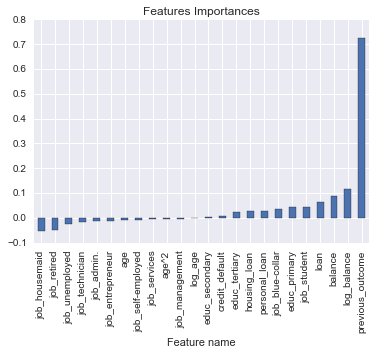

In [903]:
from sklearn.cross_validation import cross_val_score

class featureImportance:
    def __init__(self, clf, cv=5):
        self.clf = clf
        self.cv = cv

    def fit(self, X, y):
        n_features = X.shape[1]
        self.feat_importances = np.zeros(n_features)
        self.score_ = cross_val_score(clf, X, y, cv=self.cv, scoring='roc_auc').mean()
        for i in xrange(n_features):
            score_i = cross_val_score(clf, np.delete(X, i, axis=1), y, cv=self.cv, scoring='roc_auc').mean()
            self.feat_importances[i] = self.score_ - score_i
        self.feat_importances /= self.feat_importances.sum()
        
    def plot(self, labels=None):
        if labels is None:
            labels = np.arange(X.shape[1])
        else:
            labels = np.array(labels)
        pd.Series(
            np.sort(self.feat_importances),
            index=labels[np.argsort(self.feat_importances)]).plot.bar(
                title='Features Importances')
        pyplot.xlabel('Feature name')        
                
fi = featureImportance(clf)
fi.fit(X, y)
fi.plot(np.array(features_names))
fi.score_
#pyplot.plot(fi.feat_importances)

## 5 Logistic Regression
### 5.1 Hiper-parameter Tuning

## Data Modeling

In order to predict if a client subscribes the term deposit, we will use two machine learning algorithms for classification - Logistic Regression and Random Forests.

First, we split the whole data in two sets, a training set to adjust model parameters, and a test set, to evaluate its performance.

Thereafter, we create a pipeline: with a data imputer preprocesser that replaces NaN values by the mean values of a given feature, followed by the classification model itself.

The data imputation step must only be performed at this stage, since, otherwise we would include information coming from the test set in the training set.

### Cross-validation

We previously decided to randomly split the data to evaluate the model on 25% of held-out data. However the location randomness of the split might have a significant impact in the estimated accuracy.

So instead of using a single train / test split, we can use a group of them and compute mean scores.

## (Automated) Parameter Tuning

To optimize the classification, we will perform a grid search accross a series of possible values for 'max_depth' and 'criterion' parameters of the Random Forest algorithm.

Now, we compare the performance of this 'tuned model' with the previous ones:

## Feature Importance

The feature importance give us a measure of the (relative) impact that a given feature have in the overal algorithm's score.

class SBFS: # sequential backward feature selection
    def __init__(self, clf, cv=10, random_state=0):
        self.clf = sklearn.base.clone(clf)
        self.cv = cv
        self.random_state = random_state
    
    def fit(self, X, y):
        dim = X.shape[1]
        self.indices_ = np.arange(dim)
        self.score_ = cross_val_score(clf, X, y, cv=self.cv, scoring='roc_auc').mean()
        while dim>0:
            dim -= 1
            step_score = []
            subsets = []
            for p in xrange(dim):
                idx = np.delete(self.indices_, p)
                s = cross_val_score(clf, X[:, idx], y, cv=self.cv, scoring='roc_auc').mean()
                step_score.append(s)
                subsets.append(idx)
            best = np.argmax(step_score)
            best_score = step_score[best]
            self.indices_ = subsets[best]
            if best_score >= self.score_:
                self.score_ = best_score
            else:
                self.indices_ = self.indices_[np.argsort(step_score)]
                break
        return self

    def transform(self, X):
        return X[:, self.indices_]